<center><img src = "https://www.med.upenn.edu/cbica/assets/user-content/images/BraTS/BRATS_banner_noCaption.png" width = "800"/></center>
<center><str><a target="_blank" href="https://www.med.upenn.edu/cbica/assets/user-content/images/BraTS/BRATS_banner_noCaption.png">Image Source</a></str></center>

# 1. Introduction

In the last few years, the area of computer vision has undergone substantial development. This branch of technology is dedicated to the comprehensive set of processes involved in obtaining, processing, analyzing, and comprehending digital images to extract meaningful information.

One key technique among these processes is known as image segmentation. This specific method plays a crucial role in dividing an image into parts or segments to simplify or change the representation of an image into something that is more meaningful and easier to analyze. Image segmentation is fundamental in identifying objects and boundaries (lines, curves, etc.) in images, making it a critical step in many computer vision tasks.

Computer vision, with a focus on image segmentation, plays a pivotal role in medical imaging by enabling precise segmentation of brain tumors. This technology facilitates accurate tumor identification and boundary delineation within MRI scans, which is essential for diagnosis, treatment planning, and monitoring the progression of brain tumors. By automating and enhancing the analysis of medical images, image segmentation significantly contributes to improved patient outcomes in the field of neuro-oncology

![image](Images/segmentation.gif).

This notebook focuses on the preprocessing of the BraTS 2020 dataset for Brain Tumor Segmentation. The BraTS 2020 dataset consists of multimodal MRI scans along with manual segmentations of brain tumors, essential for developing machine learning models for accurate and automated tumor segmentation.

The preprocessing steps covered include:
1. **Loading the dataset and necessary libraries** to handle medical images.
2. **Splitting the dataset** into training, testing and validation sets to evaluate model performance.
3. **Visualizing MRI scans** and their corresponding ground truth segmentations to understand the datasest.
4. **Preparing the data** for modeling, including normalization, resizing and augmentation.

This preparation is crucial for any subsequent model training and evaluation, aiming to improve the accuracy and efficency of brain tumor segmentation.

# 2. Dataset Information

The Brain Tumor Segmentation (BraTS) 2020 dataset is a collection of multimodal Magnetic Resonance Imaging (MRI) scans used for the segmentation of brain tumors.

It includes MRI scans from glioma patients, providing four different MRI modalities (means 4 channels of information - 4 different volumes of the same region) per patient:
1. **Native (T1)**
2. **Post-contrast T1-weighted (T1ce - contrast enhanced)**
3. **T2-weighted (T2)**
4. **T2-FLAIR (T2 - Fluid Attenuated Inversion Recovery)**

These scans come with expert-annotated segmentation masks that delineate the tumor into various sub-regions, such as the necrotic and non-enhancing tumor core, the peritumoral edema, and the enhancing tumor.

Annotations (labels):
  1. **Label 0**: Unalbeled volume
  2. **Label 1**: Necrotic and non-enhancing tumor core (NCR/NET)
  3. **Label 2**: Peritumoral edema (ED)
  4. **Label 3**: Missing (No pixels in all the volumes contain label 3)
  5. **Label 4**: GD-enhancing tumor (ET)

As there are no pixels with the label 3, we will be reassigning label 3 with label 4 so that there is continuity between the labels.

We will combine FLAIR, T1ce and T2 into a single volume as it will give us rich information. And we will ignore T1 as the features we see in the mask are clearly visible in T1ce, T2 and FLAIR.

# 3. Loading the Necessary Libraries

In [134]:
import numpy as np
import nibabel as nib
import glob
import shutil
import os
from tensorflow.keras.utils import to_categorical
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tifffile import imsave
from skimage.util import montage
import keras
from skimage.transform import rotate
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import gif_your_nifti.core as gif2nif
import nilearn as nl
import nilearn.plotting as nlplt

# 4. Load Sample Images and Visualize

<div class="alert alert-block alert-warning">
Before moving forward, we must correct a small error in the dataset. The segmentation file in "BraTS20_Training_355" folder has an incorrect name. Now we will rename it to keep the same name as others.
</div>

In [94]:
TRAIN_DATASET_PATH = "D:/Brain Tumor Segmentation FYP/Dataset/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

In [128]:
old_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/W39_1998.09.19_Segm.nii"
new_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_seg.nii"

# renaming the file
try:
    os.rename(old_name, new_name)
    print("File renamed!")
except:
    print("File is already renamed!")

File is already renamed!


## Data Exploration

In [96]:
# load .nii file as a numpy array
test_image_flair = nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_flair.nii").get_fdata()
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)

Shape:  (240, 240, 155)
Dtype:  float64


In [97]:
print(test_image_flair.max())

1854.603271484375


As we can see the maximum pixel value of the image is "1854.6" which gives us a good idea to rescale these values. Rescaling pixel values is essential because it standardizes the intensity values across multimodal MRI scans (T1, T1ce, T2, FLAIR) to a uniform scale. This uniformity is crucial for consistent model training and analysis, as it ensures that variations in pixel intensity due to different imaging modalities and equipment do not bias the segmentation model. It facilitates the model's ability to learn meaningful features from the data for accurate tumor segmentation, regardless of the inherent differences in the raw MRI scans.

In [98]:
scaler = MinMaxScaler()

In [99]:
# Scale the test_image_flair array and then reshape it back to its original dimensions.
# This ensures the data is normalized/standardized for model input without altering its spatial structure.
test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

In [100]:
print(test_image_flair.max())

1.0


Now we can see that the pixel values are scaled between 0 - 1.

In [101]:
# rescaling t1
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# rescaling t1ce
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# rescaling t2
test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# we will not rescale the mask
test_image_seg = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()

In [102]:
print("Before: ", test_mask.dtype)

Before:  uint8


In [103]:
# converting to integer
# test_mask = test_mask.astype(np.uint8)
print("After: ", test_mask.dtype)

After:  uint8


In [104]:
#0, 1, 2, 4 (Need to re-encode to 0, 1, 2, 3)
print(np.unique(test_image_seg))

[0. 1. 2. 4.]


In [105]:
# re-assigning mask values 4 to 3
# test_image_seg[test_image_seg==4] = 3
# print(np.unique(test_image_seg))

Slice: 95th


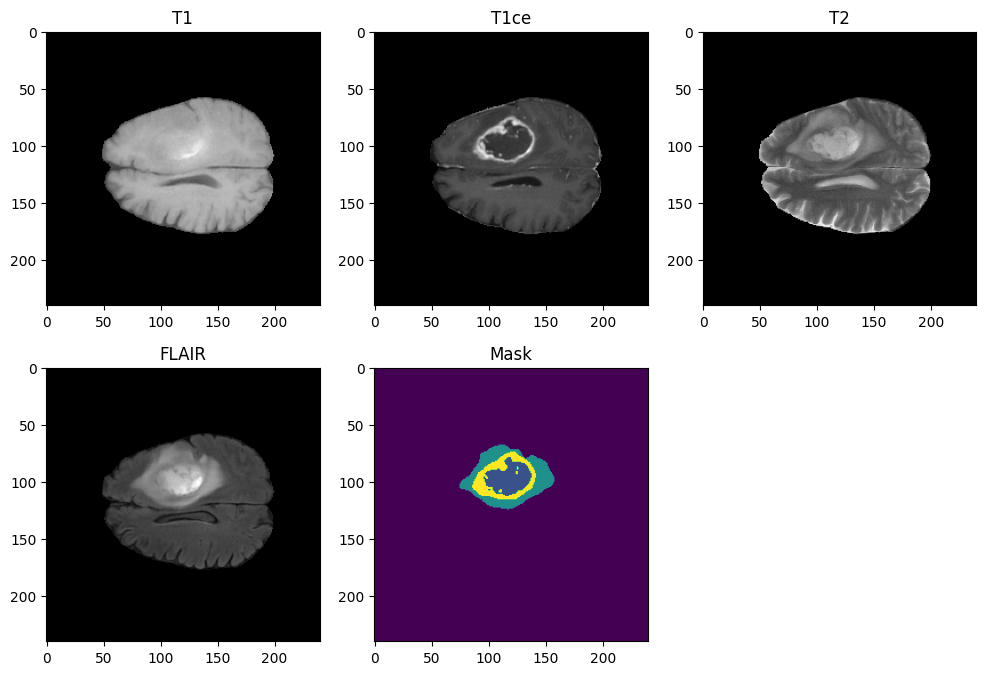

In [106]:
slice_w = 25

print("Slice: " + str(test_image_t1ce.shape[0]//2-slice_w) + "th")

plt.figure(figsize=(12, 8))

# T1
plt.subplot(2, 3, 1)
plt.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap='gray')
plt.title('T1')

# T1ce
plt.subplot(2, 3, 2)
plt.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap='gray')
plt.title('T1ce')

# T2
plt.subplot(2, 3, 3)
plt.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap='gray')
plt.title('T2')

# Flair
plt.subplot(2, 3, 4)
plt.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap='gray')
plt.title('FLAIR')

# Mask
plt.subplot(2, 3, 5)
plt.imshow(test_image_seg[:,:,test_image_seg.shape[0]//2-slice_w])
plt.title('Mask')
plt.show()

As we can see, the four modalities bring out different aspects for the same image.

To be more specific, here is a description of their interest:

- **Native (T1)**: Used to show the structure and composition of different types of tissue in the brain and to identify tumors, cysts, and other abnormalities.
- **Post-contrast T1-weighted (T1ce, also named T1Gd):** Similar to T1 images but with the injection of a contrast agent (Gadolinium) which will enhance the visibility of abnormalities.
- **T2-weighted (T2):** Used to show the fluid content of different types of tissue in the brain.
- **T2-FLAIR (T2 - Fluid Attenuated Inversion Recovery):** Used to suppress this fluid content. This can be useful for identifying lesions that are not clearly visible on T1 or T2 images, and also for identifying lesions in the white matter of the brain, which can be difficult to see on other types of scans.

For an expert, it can be useful to have these 4 modalities in order to analyze the tumor more precisely, and to confirm its presence or not.
But for our artificial approach, **using only two modalities instead of four** is interesting since it can reduce the computational and memory requirements of the segmentation task, making it faster and more efficient. That is why we will **exclude T1**, since we have its improved version T1ce. We will also **exclude the T2 modality** because the fluids it presents could degrade our predictions. These fluids are removed in the flair version, which highlights the affected regions much better, and will therefore be much more interesting for our training.

## Images Format

You may have noticed that these images are in `.nii` format. These scans are NIfTI files (*Neuroimaging Informatics Technology Initiative*). A NIfTI image is a digital representation of a 3D object, such as a brain in our case. To understand this more closely, let's display the shape of a modality scan and of a segmentation (they all have the same in this dataset): 

In [107]:
# Modality shape
print("Modality: ", test_image_t1.shape)

# Segmentation shape
print("Segmentation: ", test_mask.shape)

Modality:  (240, 240, 155)
Segmentation:  (240, 240, 155)


As we can see, modalities & segmentations do have 3 dimensions. Each dimension is composed of a series of two-dimensional images, known as **slices**, which all contain the same number of pixels, and are stacked together to create this 3D representation. That is why we have displayed 2D images just above (you may not have noticed but we have displayed the **95th slice** of a certain dimension).

These 3 dimensions correspond to the three spatial dimensions of the image : width, height, and depth. In medical imaging, they are named `axial/transverse, coronal, and sagittal planes`, corresponding to the three main orientations of the human body, and therefore the human brain.

Here is a quick presentation of these 3 planes: 
 
<center><img src = "https://i0.wp.com/www.rishacademy.com/wp-content/uploads/2021/06/anatomicalplanes.png?fit=540%2C430&ssl=1" width = "500"/></center>
<center><str><a target="_blank" href="https://i0.wp.com/www.rishacademy.com/wp-content/uploads/2021/06/anatomicalplanes.png?fit=540%2C430&ssl=1">Image Source</a></str></center>

- **Transverse/Axial Plane**: It divides the body into top and bottom sections and is often referred to as a "head-toe" plane.
- **Frontal/Coronal Plane**: It divides the body into front and back sections and is often referred to as a "side-side" plane.
- **Sagittal/Lateral Plane**: It divides the body into left and right sections and is often referred to as a "front-back" plane.

We can display each modality through its different planes. For example, we will display the 3 planes of the T1 image:

Slice: 95th


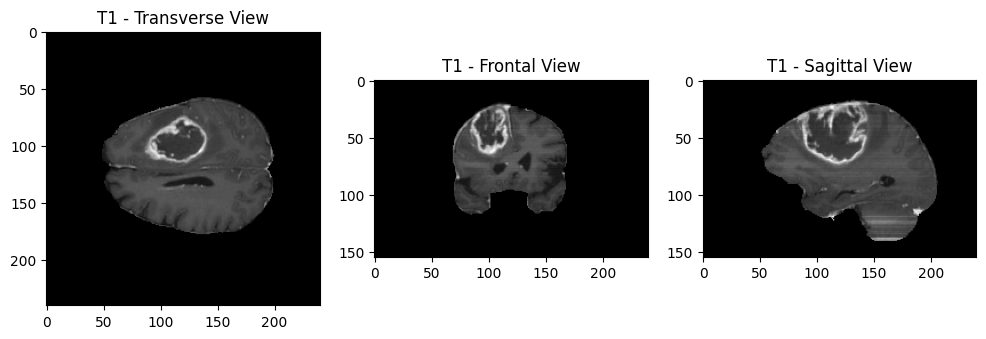

In [108]:
slice_w = 25

print("Slice: " + str(test_image_t1ce.shape[0]//2-slice_w) + "th")

plt.figure(figsize=(12, 8))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
# T1 - Transverse View
plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap='gray')
plt.title('T1 - Transverse View')

# T1 - Frontal View
plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t1ce[:,test_image_t1ce.shape[0]//2-slice_w,:], 90, resize=True), cmap='gray')
plt.title('T1 - Frontal View')

# T1 - Sagittal View
plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t1ce[test_image_t1ce.shape[0]//2-slice_w,:,:], 90, resize=True), cmap='gray')
plt.title('T1 - Sagittal View')
plt.show()

Now that we know why we have three dimensions, let's try to understand why we chose to display a specific slice. 

To do this, we will display all the slices: 

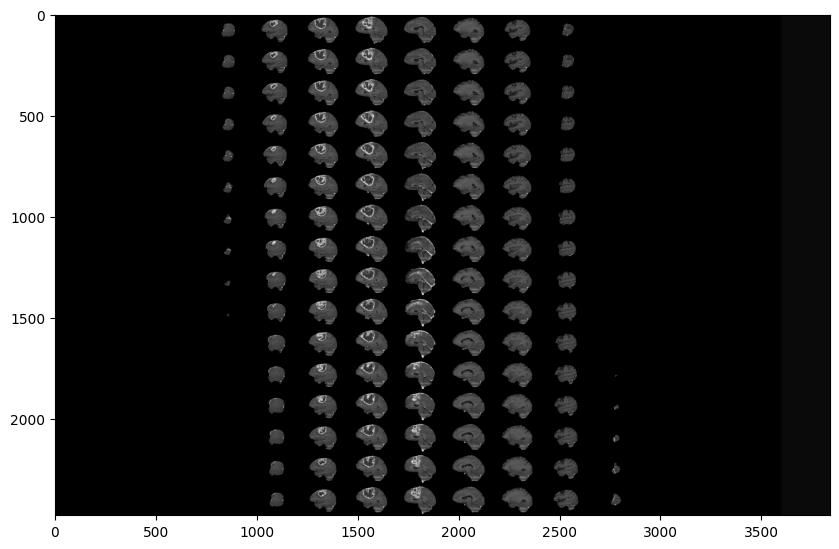

In [109]:
fig, ax1 = plt.subplots(1, 1, figsize = (10,10))
# montage allows us to concatenate multiple images of the same size horizontally and vertically
ax1.imshow(rotate(montage(test_image_t1ce[:,:,:]), 90, resize=True), cmap ='gray');

As we can see, the two dark areas are present on each side of our montage. However, these dark areas correspond to the first and last slices of a plane. This means that a large part of the slices does not contain much information. This is not surprising since the slices progressively represent the brain.

This analysis is the same on all other modalities, all planes and also on the images segmented by the experts. Indeed, they were not able to segment the slices that do not contain much information.

This is why we can exclude these slices in our analysis, in order to reduce the number of manipulated images. We can see that a `(60:135)` range will be much more interesting:

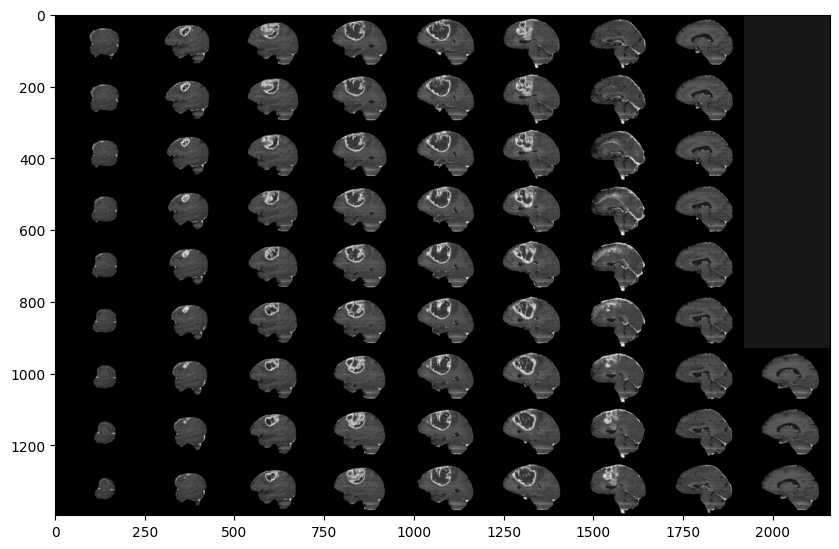

In [120]:
# Skip 60:135 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (10,10))
ax1.imshow(rotate(montage(test_image_t1ce[60:135,:,:]), 90, resize=True), cmap ='gray');

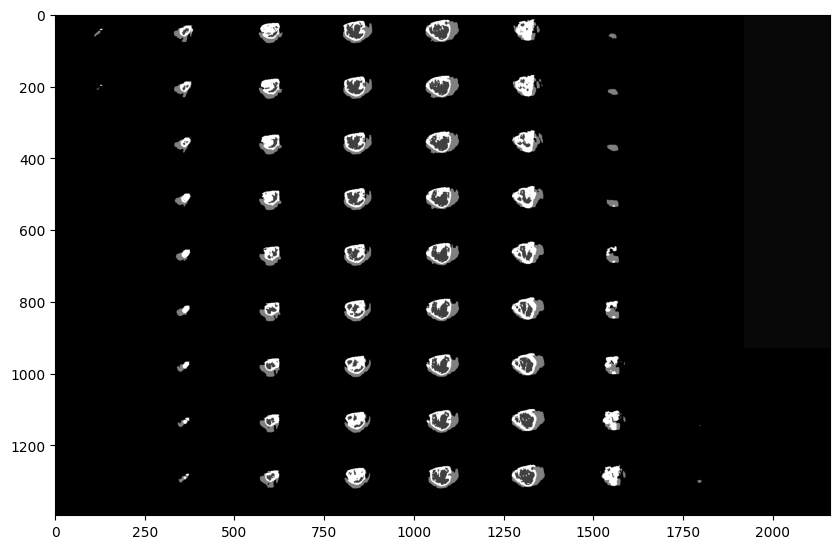

In [121]:
# Skip 60:135 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (10,10))
ax1.imshow(rotate(montage(test_image_seg[60:135,:,:]), 90, resize=True), cmap ='gray');

Now, let's focus on the segmentations provided by the experts. What information do they give us? 

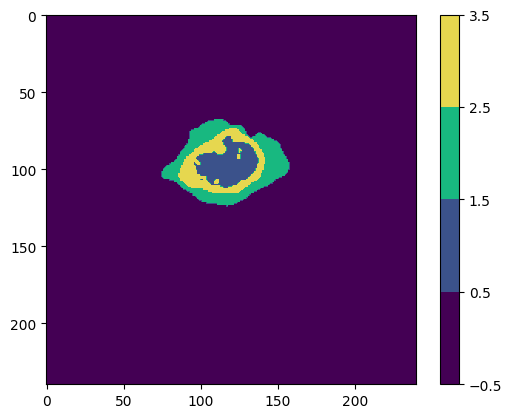

In [112]:
# Plotting the segmantation
cmap = matplotlib.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# plotting the 95th slice
plt.imshow(test_image_seg[:,:,95], cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

Regardless of the plane we are viewing, we will notice that some slices have multiple colors (here 4 colors), which means that the experts have assigned multiple values to the segmentation. Let's see what values are possible in this dataset:

In [113]:
# seg_samples = [os.path.join(TRAIN_DATASET_PATH, sample, f"{sample}_seg.nii") for sample in os.listdir(TRAIN_DATASET_PATH) if not sample.endswith('.csv')]

# saved_values = []
# max_nb_values = 0
# for sample in seg_samples:
#     seg_img = nib.load(sample).get_fdata()
#     unique_values = np.unique(seg_img)
#     nb_unique_values = len(np.unique(seg_img))
    
#     if nb_unique_values > max_nb_values:
#         max_nb_values = nb_unique_values
#         saved_values = unique_values

# print(f"Maximum number of values in all segmentation images: {max_nb_values}")
# print(f"Values: {saved_values}")

We notice that there are **4 possible values in the segmentation files**. These 4 values will form our 4 classes. Here is what they correspond to: 

- **0** : Not Tumor (NT) which means Healthy Zone or Background
- **1** : Necrotic and Non-Enhancing Tumor (NCR + NET)
- **2** : Peritumoral Edema (ED)
- **4** : Enhancing Tumor (ET)

As we can see, class 3 does not exist. We go directly to 4. We will therefore modify this “error” before sending the data to our model.

Our goal is to predict and segment each of these 4 classes for new patients to find out whether or not they have a brain tumor and which areas are affected.

Let's now take a look at the distribution of these 4 values:

In [114]:
value, counts = np.unique(test_image_seg, return_counts = True)
print(counts)

[8789976   32235   45483   60306]


We see that the previous segmentation has a lot of annotated data fixed to 0, which corresponds to the background (useless information). We might consider cropping our images to eliminate some of this useless area, to reduce the complexity of the segmentation task and thus speed up our training by reducing processing time.

Let's see what these 4 different classes correspond to, by displaying the classes one by one:

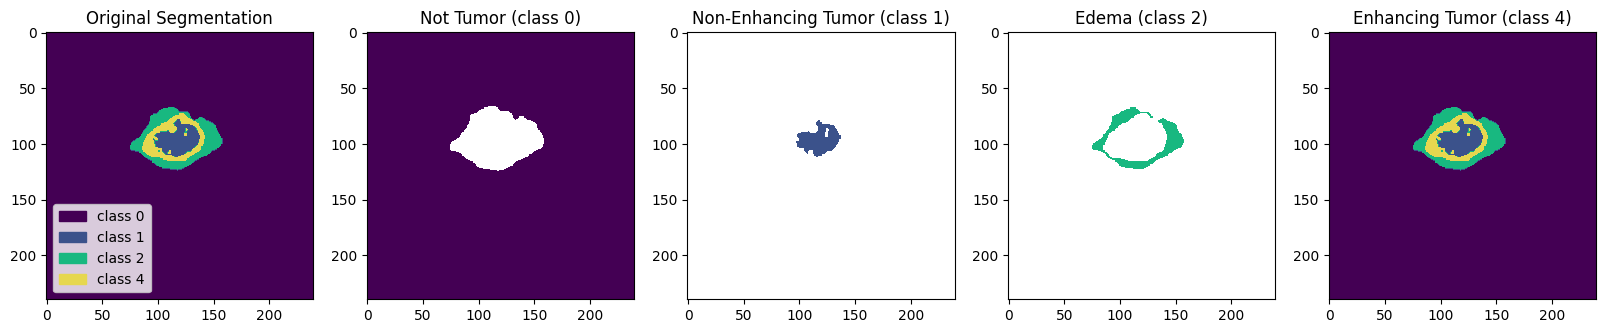

In [117]:
# Deletion of class 0
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_4 = test_image_seg.copy()
seg_3[seg_4 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 4']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, ax = plt.subplots(1, 5, figsize=(20, 20))

ax[0].imshow(test_image_seg[:,:, 95], cmap=cmap, norm=norm)
ax[0].set_title('Original Segmentation')
ax[0].legend(handles=legend, loc='lower left')

ax[1].imshow(seg_0[:,:, 95], cmap=cmap, norm=norm)
ax[1].set_title('Not Tumor (class 0)')

ax[2].imshow(seg_1[:,:, 95], cmap=cmap, norm=norm)
ax[2].set_title('Non-Enhancing Tumor (class 1)')

ax[3].imshow(seg_2[:,:, 95], cmap=cmap, norm=norm)
ax[3].set_title('Edema (class 2)')

ax[4].imshow(seg_4[:,:, 95], cmap=cmap, norm=norm)
ax[4].set_title('Enhancing Tumor (class 4)')

plt.show()

**To summarize data exploration:**

- We have for each sample / patient 4 different modalities **(T1, T1CE, T2 & FLAIR)**, accompanied by a segmentation that indicates tumor areas.

- Modalities **T1CE** and **FLAIR** are the more interesting to keep, since these 2 provide complementary information about the anatomy and tissue contrast of the patient’s brain.

- Each image is 3D, and can therefore be analyzed through **3 different planes** that are composed of 2D slices.

- Many slices contain little or no information. We will only **keep the (70:134)** slices interval for this notebook. Of course, we are free to customize the code to send less or more slices to your model, but the training time will be longer.

- A segmentation image contains **0, 1, 2 & 4**. 

- Class number **4 must be reassigned to 3** since value 3 is missing. 

- Class 0 (background) is **over-represented** in the majority of the scans. However, cropping can remove important information. We will not do it and will keep the images as they are.

Now that we know more about our data, it is time to prepare it for the training of our model.

In [122]:
# Define selected slices range
VOLUME_START_AT = 60 
VOLUME_SLICES = 75 

# 5. Preparing the Data for Training

## Splitting the Data into 3 Sets
In the world of AI, the quality of a model is determined by its **ability to make accurate predictions on new, unseen data**. To achieve this, it is important to divide our data into three sets: **Training, Validation and Test**.

Reminder of their usefulness: 
- **Training set** is used to train the model. During training, the model is exposed to the training data and adjusts its parameters to minimize the error between its predictions and the Ground truth (segmentations).

- **Validation set** is used to fine-tune the hyperparameters of our model, which are set before training and determine the behavior of our model. The aim is to compare different hyperparameters and select the best configuration for our model.

- **Test set** is used to evaluate the performance of our model after it has been trained, to see how well it performs on unseen data.

As we said before, The BraTS2020 dataset is already divided in 2 folders: a training folder and a validation folder. 

Unfortunately, the validation folder does not contain the segmented data and therefore cannot be used. This is why we will ignore the samples that are in this folder and create our own validation set.

First, let's retrieve all samples that are present in the training folder:

In [123]:
# Retrieve all samples from path with listdir(). This method lists of all files + directories in the specified directory.
samples = os.listdir(TRAIN_DATASET_PATH)
print("Number of samples:", len(samples))

Number of samples: 371


We obtain 371 files while the BraTS2020 training dataset contains only **369 samples**. The reason is simple: 2 `.csv` files are present in the training directory and have therefore been added to our samples list. So we are going to remove them: 

In [127]:
try:
    samples.remove("survival_info.csv")
    samples.remove("name_mapping.csv")
except:
    print("Files are already removed!")

Files are already removed!


Now, let's create our 3 different sets: 

In [132]:
# Splitting the dataset into train and validation sets
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)

# Splitting the train set into the real train set and in a test set 
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(samples_train)}")
print(f"Validation length: {len(samples_val)}")
print(f"Test length: {len(samples_test)}")

Train length: 250
Validation length: 74
Test length: 45


![image.png](Images/data_distribution.png)

## Creating a DataGenerator

In order to train a neural network to segment objects in images, it is necessary to feed it with both the raw image data (X) and the ground truth segmentations (y). By combining these two types of data, the neural network can learn to recognize tumor patterns and make accurate predictions about the contents of a patient’s scan.

Unfortunately, our modalities images (X) and our segmentations (y) cannot be sent directly to the AI model. Indeed, loading all these 3D images would overload the memory of our environment and cause the system to crash. This will also lead to shape mismatch errors. We have to do some image preprocessing before, which will be done by using a **Data Generator**, where we will **perform any operation** that we think is necessary when loading the images.

    
More specifically, we will, for each sample:

- Retrieve the paths of its modalities (T1CE & FLAIR, since these 2 provide complementary information about the anatomy and tissue contrast of the brain)

- Retrieve the path of the Ground truth (original segmentation)

- Load modalities & segmentation

- Create a X array that will contain all the selected slices (60-135) of these 2 modalities.

- Create an y array that will contain all the selected slices of the segmentation.

- Assign to all the 4 in the mask array the value 3 (in order to correct the 3 missing case explained previously).

In addition to these preprocessing steps, we will:

- **Work in the Axial plane**: Since the images are square in shape (240x240) in this plane. But since we will manipulate a range of slices, we will be able to visualize the predictions in the 3 planes, so it doesn't really have an impact.

- **Apply a One-Hot Encoder to the y array**: Since our goal is to segment regions that are represented as different classes (0 to 3), we must use One-Hot Encoding to convert our categorical variables (classes) into a numerical representation that can be used by our neural network (since they are based on mathematical equations). Indeed, from a mathematical point of view, sending the y array as it is would mean that some classes are superior to others, while there is no superiority link between them. For example, class 1 is inferior to class 4 since 1 < 4. A One-Hot encoder will allow us to manipulate only 0 and 1. Here is what it consists of, for one slice: 

![image](Images/one_hot_encoding.png)

- **Resize each slice of our images from (240x240) to a (128, 128) shape**: Resizing slices from (240x240) to (128x128) is needed since we need image shapes that are a power of two (2<sup>n</sup>, where n is an integer). This is due to the fact that we will use pooling layers (MaxPooling2D) in our convolutional neural network (CNN), which reduce the spatial resolution by 2.

You may wonder why we didn't resize the images in a (256, 256) shape, which also is a power of 2 and is closer to 240 than 128 is.

This choice depends on several factors, such as the complexity of the model, the amount of training data, the computational resources available, and the desired balance between computational efficiency and information preservation.

Indeed, resizing images to (256, 256) may preserve more information than resizing to (128, 128), which could lead to better performance. However, this larger size also means that the model will have more parameters, which can increase the training time and memory requirements, which is the reason why we will choose the (128, 128) shape.

*Of course, you are free to train your model with (256, 256) images, but keep in mind you will have to adapt your U-Net architecture.*

In [136]:
IMG_SIZE = 128

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim # Resized image dimensions (128 x 128)
        self.batch_size = batch_size #  Number of images to load each time
        self.list_IDs = list_IDs # Patients IDs
        self.n_channels = n_channels # Number of channels (T1CE + FLAIR)
        self.shuffle = shuffle # Indicates if data is shuffled for each epoch
        self.on_epoch_end() # Updates indexes after each epoch

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Load & Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))

        # Generate data
        for c, i in enumerate(Batch_ids):
            
            # Get path of each RMI modality and the segmentation
            sample_path = os.path.join(data_path, i, i)
            t1ce_path = sample_path + '_t1ce.nii'
            flair_path = sample_path + '_flair.nii'
            seg_path = sample_path + '_seg.nii'
            #t1_path = sample_path + '_t1.nii'
            #t2_path = sample_path + '_t2.nii'
            
            # Extract the data from these paths
            t1ce = nib.load(t1ce_path).get_fdata()
            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()
            #t1 = nib.load(t1_paths).get_fdata()
            #t2 = nib.load(t2_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]
                    
        # Masks / Segmentations
        y[y==4] = 3
        mask = tensorflow.one_hot(y, 4)
        Y = tensorflow.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        
        # Scale data between 0 and 1 (since the minimum value in the data is 0)
        return X/np.max(X), Y
        
training_generator = DataGenerator(samples_train)
valid_generator = DataGenerator(samples_val)
test_generator = DataGenerator(samples_test)

**To summarize the preprocessing steps**:
- We use a data generator to be able to process and send our data to our neural network (since all our images cannot be stored in memory at once).
- For each epoch (single pass of the entire training dataset through a neural network), the model will receive 250 samples (those contained in our training dataset).
- For each sample, the model will have to analyze 150 slices (since there are two modalities, and 75 selected slices for both of them), received in a (128, 128) shape, as an X array of a (128, 128, 75, 2) shape. This array will be provided with the ground truth segmentation of the patient, which will be One-Hot encoded and will then have a (75, 128, 128, 4) shape.